In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:


df = pd.read_csv("london_weather_data_1979_to_2023.csv")
df2 = pd.read_csv("london_energy.csv")

# Convert temperature from 0.1°C to °C
df['TX'] = df['TX'] / 10

In [3]:
avg_kwh = df2.groupby('Date')['KWH'].mean()
avg_kwh = pd.DataFrame({'date':avg_kwh.index.tolist(), 'consumption':avg_kwh.values.tolist()})
avg_kwh['date'] = pd.to_datetime(avg_kwh['date'])

In [4]:
# Step 2: Convert the weather data 'DATE' column to datetime
# Keep DATE column as datetime (do not convert to string)
df['date'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

In [ ]:
threshold_temp = 25  # °C
window = 3

#Identify hot days
df["is_hot"] = df["TX"] >= threshold_temp

#Find consecutive hot days
df["consecutive_hot_days"] = df["is_hot"].rolling(window=window, min_periods=window).sum()

#Define heatwave criteria: 3+ days with max temp ≥ 25°C in London
#In the UK, a heatwave is declared when the daily temperature of a certain location meets or exceeds the heatwave temperature threshold for at least three days.
# Check if the current day is part of a qualifying streak(3)

df["is_heatwave"] = False

# M ark days as heatwave if they are hot and there's a streak
for i in range(len(df)):
    if df.iloc[i]["is_hot"]: #Check specific day forwards and backwards to see if part of heatwave
        start_check = max(0, i - window + 1)
        end_check = min(len(df), i + window)
        
        for start_pos in range(start_check, i + 1):
            end_pos = start_pos + window
            if end_pos <= len(df):
                streak = df.iloc[start_pos:end_pos]["is_hot"].sum()
                if streak >= window and start_pos <= i < end_pos:
                    df.iloc[i, df.columns.get_loc("is_heatwave")] = True
                    break

# Create heatwave groups
df['heatwave_group'] = 0
current_group = 0

for i in range(len(df)):
    if df.iloc[i]['is_heatwave']:
        if i == 0 or not df.iloc[i-1]['is_heatwave']:
            # s tart of new heatwave
            current_group += 1
        df.iloc[i, df.columns.get_loc('heatwave_group')] = current_group

# Clean up tempcolumns
columns_to_drop = []
if 'is_hot' in df.columns:
    columns_to_drop.append('is_hot')
if 'hot_day_group' in df.columns:
    columns_to_drop.append('hot_day_group')
if columns_to_drop:
    df.drop(columns=columns_to_drop, inplace=True)

# Display results
print("Columns in dataframe:", df.columns.tolist())
print("\nLast 5 days of dataset:")
print(df[["DATE", "TX", "is_heatwave"]].tail())
print()

# Check for heatwaves
summer_heatwaves = df[df['is_heatwave'] == True]
print(f"Total number of heatwave days: {len(summer_heatwaves)}")
print(f"Number of separate heatwave events: {df['heatwave_group'].max()}")
print("\nFirst few heatwave records:")
print(summer_heatwaves[["DATE", "TX", "is_heatwave", "heatwave_group"]].head(10))

# heatwave events summary
print("\n" + "="*50)
print("HEATWAVE EVENTS SUMMARY")
print("="*50)

heatwave_events = []
for group in range(1, df['heatwave_group'].max() + 1):
    group_data = df[df['heatwave_group'] == group]
    if len(group_data) > 0:
        if 'date' in df.columns:
            start_date = group_data['date'].min()
            end_date = group_data['date'].max()
        else:
            start_date = pd.to_datetime(group_data['DATE'].astype(str).min(), format='%Y%m%d')
            end_date = pd.to_datetime(group_data['DATE'].astype(str).max(), format='%Y%m%d')
        
        duration = len(group_data)
        max_temp = group_data['TX'].max()
        avg_temp = group_data['TX'].mean()
        
        heatwave_events.append({
            'Event': group,
            'Start_Date': start_date.strftime('%Y-%m-%d'),
            'End_Date': end_date.strftime('%Y-%m-%d'),
            'Duration_Days': duration,
            'Max_Temp_C': round(max_temp, 1),
            'Avg_Temp_C': round(avg_temp, 1)
        })

# convert to df for display
events_df = pd.DataFrame(heatwave_events)
print(events_df.head(10))

# stats
print(f"\nHEATWAVE STATISTICS:")
print(f"Average heatwave duration: {events_df['Duration_Days'].mean():.1f} days")
print(f"Longest heatwave: {events_df['Duration_Days'].max()} days")
print(f"Shortest heatwave(minimum to be declared): {events_df['Duration_Days'].min()} days")
print(f"Highest temperature during heatwaves: {events_df['Max_Temp_C'].max()}°C")

# specific heatwave example
print(f"\nEX: Heatwave Event #1 details:")
first_heatwave = df[df['heatwave_group'] == 1]
if 'date' in df.columns:
    print(first_heatwave[['DATE', 'TX', 'is_heatwave']].to_string(index=False))
else:
    print(first_heatwave[['DATE', 'TX', 'is_heatwave']].to_string(index=False))

Columns in dataframe: ['DATE', 'TX', 'Q_TX', 'TN', 'Q_TN', 'TG', 'Q_TG', 'SS', 'Q_SS', 'SD', 'Q_SD', 'RR', 'Q_RR', 'QQ', 'Q_QQ', 'PP', 'Q_PP', 'HU', 'Q_HU', 'CC', 'Q_CC', 'date', 'consecutive_hot_days', 'is_heatwave', 'heatwave_group']

Last 5 days of dataset:
           DATE    TX  is_heatwave
16431  20231227  12.6        False
16432  20231228  11.9        False
16433  20231229  12.2        False
16434  20231230  10.7        False
16435  20231231  12.4        False

Total number of heatwave days: 899
Number of separate heatwave events: 171

First few heatwave records:
         DATE    TX  is_heatwave  heatwave_group
204  19790724  25.2         True               1
205  19790725  27.1         True               1
206  19790726  29.9         True               1
207  19790727  27.4         True               1
518  19800602  25.6         True               2
519  19800603  29.0         True               2
520  19800604  27.0         True               2
944  19810802  25.9         True

In [6]:
merged_df = pd.merge(avg_kwh, df.drop(columns=['DATE']), on='date', how='inner')

In [7]:
print(merged_df.isna().any()[lambda x: x])

print(merged_df.info())

columns_to_fill = ['HU', 'CC']
merged_df[columns_to_fill] = merged_df[columns_to_fill].ffill()

print(merged_df.info())

HU    True
CC    True
dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  829 non-null    datetime64[ns]
 1   consumption           829 non-null    float64       
 2   TX                    829 non-null    float64       
 3   Q_TX                  829 non-null    int64         
 4   TN                    829 non-null    float64       
 5   Q_TN                  829 non-null    int64         
 6   TG                    829 non-null    float64       
 7   Q_TG                  829 non-null    int64         
 8   SS                    829 non-null    float64       
 9   Q_SS                  829 non-null    int64         
 10  SD                    829 non-null    float64       
 11  Q_SD                  829 non-null    int64         
 12  RR                    829 non-null    float6

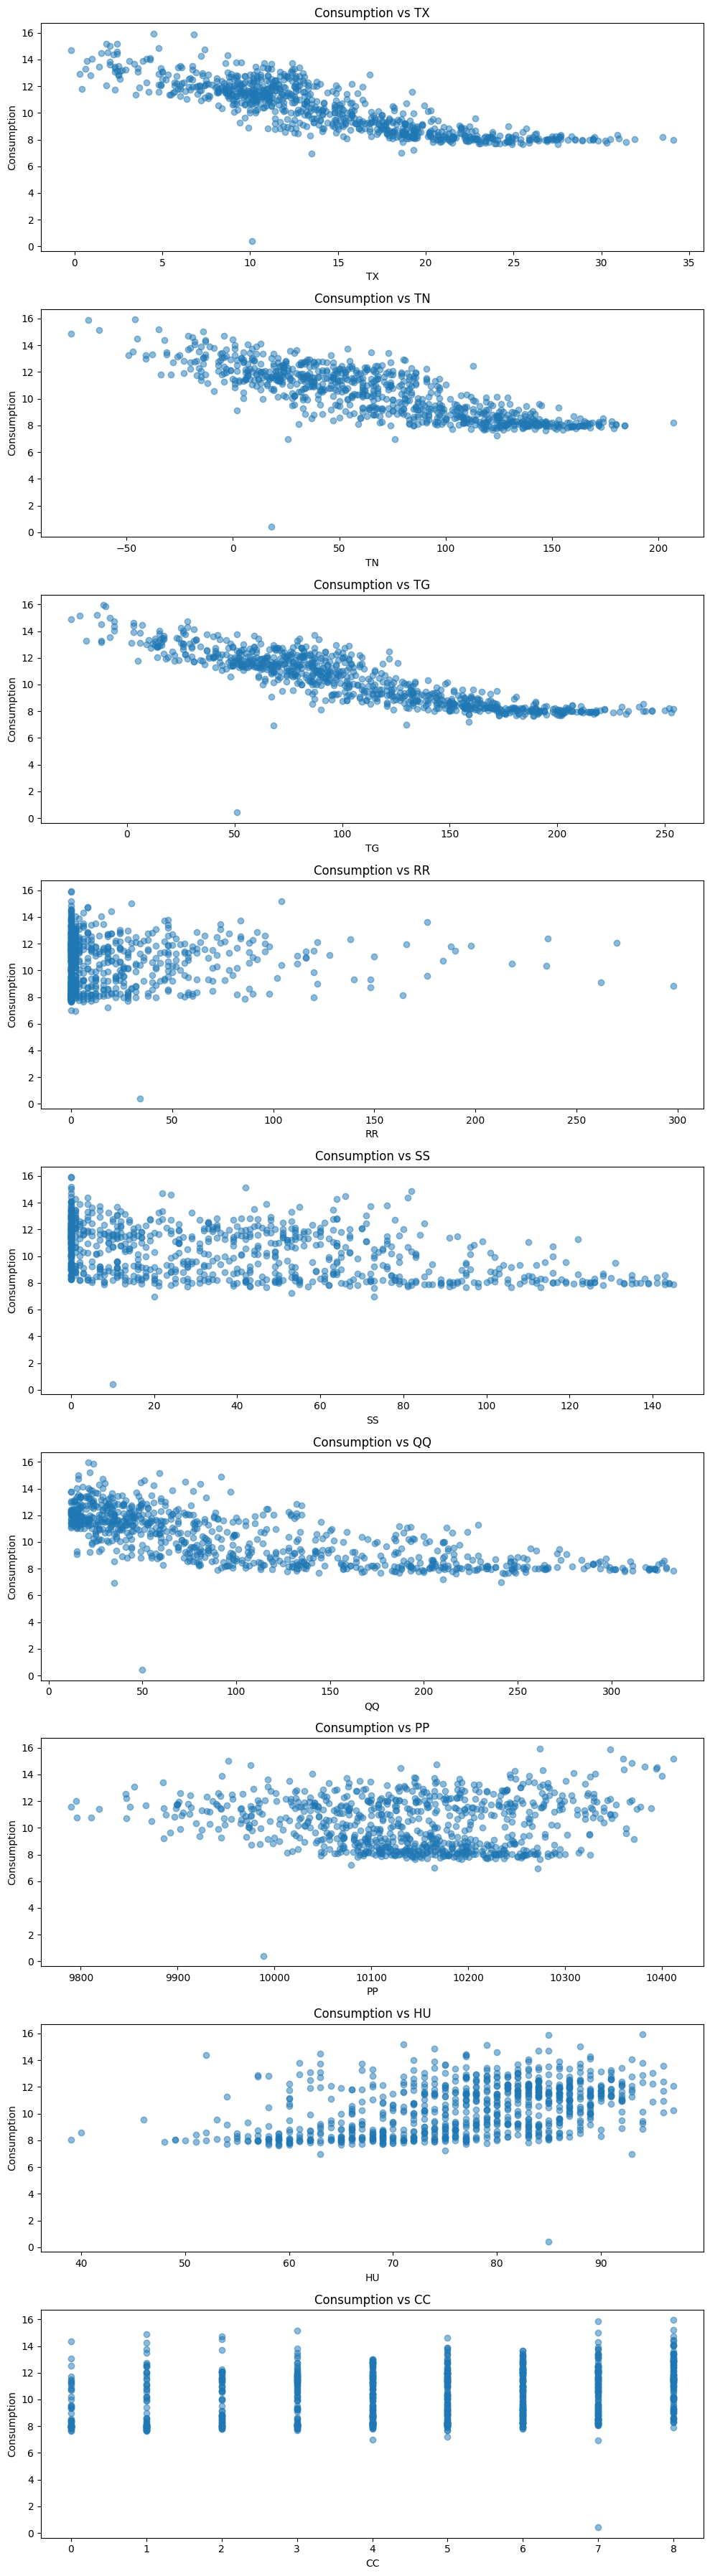

In [8]:

valid_features_to_plot = ['TX', 'TN', 'TG', 'RR', 'SS', 'QQ', 'PP', 'HU', 'CC']

# Create subplots
fig, axes = plt.subplots(nrows=len(valid_features_to_plot), ncols=1, figsize=(10, 4 * len(valid_features_to_plot)))

for i, feature in enumerate(valid_features_to_plot):
    axes[i].scatter(merged_df[feature], merged_df['consumption'], alpha=0.5)
    axes[i].set_title(f'Consumption vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Consumption')

plt.tight_layout()
plt.show()